# Death to Cluster Models; Long Live Context Encoders
Outline:
- global vs. cluster vs. context regression (MSE and L2) with continuously-varying parameters
- global vs. cluster vs. context networks (L2) with continuously-varying parameters

We don't see all values of C but with a context encoder we can fill in the gaps rather than referring to the nearest cluster. This is important because gaps often represent:
- Undocumented / undiscovered treatments
- Undersampled / underrepresented patient populations
- Rare cell types / diseases / risk factors

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.cluster import KMeans
from contextualized.regression import ContextualizedRegression, RegressionTrainer
from contextualized.networks import ContextualizedCorrelation, NetworkTrainer

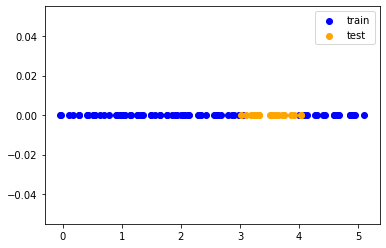

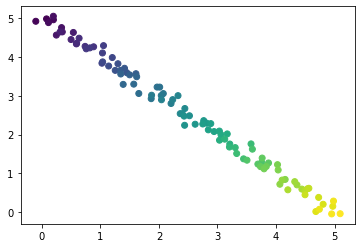

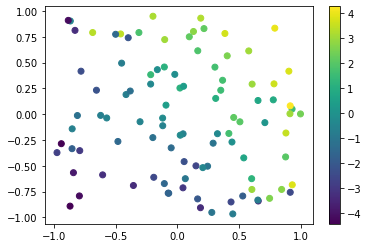

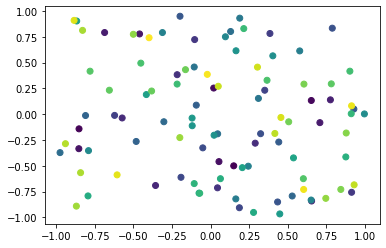

In [77]:
n_z = 100
Z = np.linspace(0, 5, n_z)
z_samples = 1
Z_labels = np.repeat(Z, z_samples, axis=0)
C = Z_labels.copy()[:, np.newaxis]
C += np.random.normal(0, .1, C.shape)

W_true = np.array([Z, Z[::-1]]).T
W = np.repeat(W_true, z_samples, axis=0)
W += np.random.normal(0, .1, W.shape)
X = np.random.uniform(-1, 1, W.shape)
Y = (X * W).sum(axis=1)[:, np.newaxis]
Y += np.random.normal(0, .1, Y.shape)

train_idx = np.array(list(range(0, 60)) + list(range(80, 100)))
test_idx = np.array(list(range(60, 80)))
split = lambda arr: (arr[train_idx], arr[test_idx])
Z_train, Z_test = split(Z_labels)
C_train, C_test = split(C)
W_train, W_test = split(W)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)

plt.scatter(C_train, np.zeros_like(C_train), c='blue', label='train')
plt.scatter(C_test, np.zeros_like(C_test), c='orange', label='test')
plt.legend()
plt.show()
plt.scatter(W[:,0], W[:,1], c=Z_labels)
plt.show()
plt.scatter(X[:,0], X[:,1], c=Y)
plt.colorbar()
plt.show()
plt.scatter(X[:,0], X[:,1], c=Z_labels)
plt.show()

In [48]:
# Models
mse = lambda true, pred: ((true - pred)**2).mean()

class NaiveRegression:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ Y
        return self
        
    def predict_w(self, X):
        return np.tile(self.w.T, (len(X), 1))
    
    def predict_y(self, X):
        w_hat = self.predict_w(X)
        y_hat = (X * w_hat).sum(axis=1)[:, np.newaxis]
        return y_hat


class ClusterRegression:
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K)
        self.models = {k: NaiveRegression() for k in range(K)}
    
    def fit(self, C, X, Y):
        self.kmeans.fit(C)
        for k in range(self.K):
            k_idx = self.kmeans.labels_ == k
            X_k, Y_k = X[k_idx], Y[k_idx]
            self.models[k].fit(X_k, Y_k)
        return self
            
    def predict_l(self, C):
        return self.kmeans.predict(C)
    
    def predict_w(self, C, X):
        labels = self.predict_l(C)
        w_hat = np.zeros_like(X)
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            w_hat[l_idx] = self.models[label].predict_w(X_l)
        return w_hat
    
    def predict_y(self, C, X):
        labels = self.predict_l(C)
        y_hat = np.zeros((len(X), 1))
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            y_hat[l_idx] = self.models[label].predict_y(X_l)
        return y_hat

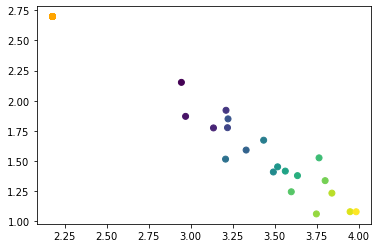

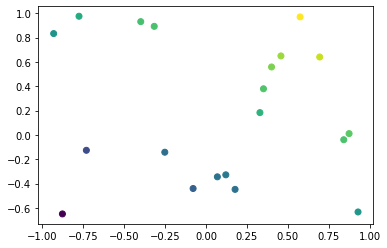

mse: 1.3987247052163132, l2: 1.6442043942624622


In [49]:
# Population regression
naive_model = NaiveRegression().fit(X_train, Y_train)
w_hat = naive_model.predict_w(X_test)
y_hat = naive_model.predict_y(X_test)

plt.scatter(W_test[:,0], W_test[:,1], c=Z_test)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

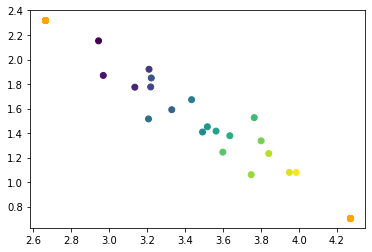

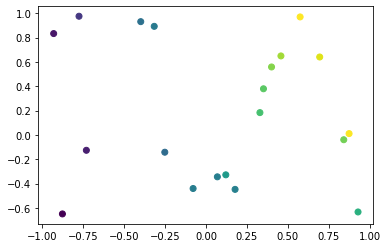

mse: 0.2123530337785661, l2: 0.3512068768388672


In [55]:
# Cluster regression
cluster_model = ClusterRegression(10).fit(C_train, X_train, Y_train)
w_hat = cluster_model.predict_w(C_test, X_test)
y_hat = cluster_model.predict_y(C_test, X_test)

plt.scatter(W_test[:,0], W_test[:,1], c=Z_test)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

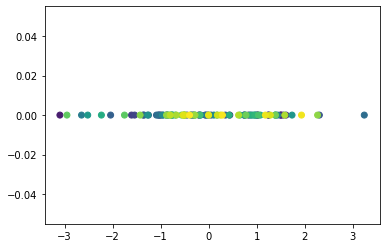

In [57]:
# noise-context sanity check
noise = np.random.normal(0, 1, C.shape)
noise_train, noise_test = split(noise)
model = ContextualizedRegression(noise.shape[-1], X.shape[-1], Y.shape[-1])

plt.scatter(noise, np.zeros_like(noise), c=Z_labels)
plt.show()

In [59]:
train_dataloader = model.dataloader(noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(noise_test, X_test, Y_test, batch_size=100)
trainer = RegressionTrainer(max_epochs=20, auto_lr_find=True)
trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 340   
-----------------------------------------------
340       Trainable params
0         Non-trainable params
340       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 79it [00:00, ?it/s]

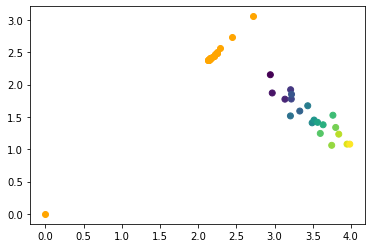

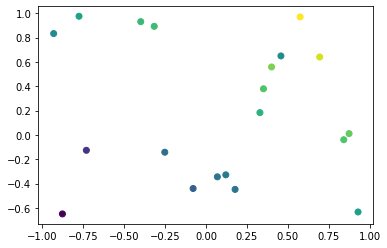

mse: 1.4664812575916808, l2: 1.677919773100306


In [60]:
w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W_test[:,0], W_test[:,1], c=Z_test)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

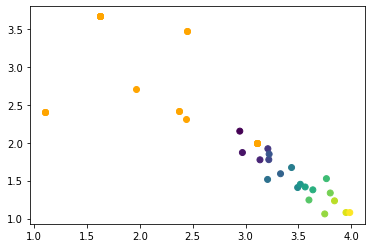

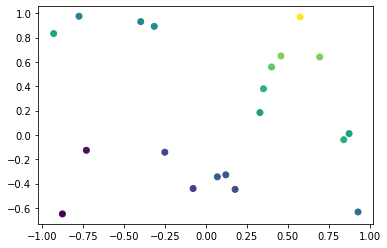

mse: 1.735723623061394, l2: 2.227031459443676


In [65]:
# Cluster regression on noise
cluster_model = ClusterRegression(8).fit(noise_train, X_train, Y_train)
w_hat = cluster_model.predict_w(noise_test, X_test)
y_hat = cluster_model.predict_y(noise_test, X_test)

plt.scatter(W_test[:,0], W_test[:,1], c=Z_test)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

In [68]:
# Contextualized model
model = ContextualizedRegression(C.shape[-1], X.shape[-1], Y.shape[-1])
train_dataloader = model.dataloader(C_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_test, X_test, Y_test, batch_size=100)
trainer = RegressionTrainer(max_epochs=20, auto_lr_find=True)
trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 340   
-----------------------------------------------
340       Trainable params
0         Non-trainable params
340       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 79it [00:00, ?it/s]

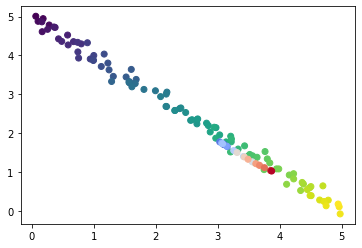

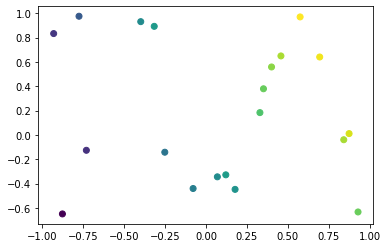

mse: 0.03009363294792437, l2: 0.02268922422344726


In [71]:
w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
w_hat[0] = w_hat[1]  # hotfix for trainer.predict_w artifact
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W[:,0], W[:,1], c=Z_labels)
plt.scatter(w_hat[:,0], w_hat[:,1], c=Z_test, cmap='coolwarm')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")